# Sensor failure Detection and prediction


## Initialize Imports and mount the dataset

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import datetime
DataSet = 'sensor.csv'
# DataSet = '/content/SensorFailurePrediction/sensor-fault-detection.csv'

## Create Helper Functions

### Plot Per Columns Distribution

In [62]:
def plotPerColumnsDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize=(6*nGraphPerRow, 8*nGraphRow), dpi = 80, facecolor= 'w', edgecolor='k')
    
    for i in range(min(nCol, nGraphShown)) :
        plt.subplot(nGraphRow, nGraphPerRow, i+1)
        columnDF = df.iloc[:,i]
        if (not np.issubdtype(type(columnDF.iloc[0]),np.number)):
            valueCounts = columnDF.value_counts()
            valueCounts.plot.bar()
            
        else:
            columnDF.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 
    plt.show()

### Plot Correlation Matrix

In [63]:
def plotCorrelationMatrix(df, graphWidth):
    fileName = df.dataframeName
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    
    if df.shape[1] < 2:
        print(f'No Correlation plots to show\n num of Nan or constant columns({df.shape[1]}) is less than 2') 
        return
    corr = df.corr()
    plt.figure(num=None, figsize = (graphWidth, graphWidth),  dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {fileName}', fontsize= 15)
    plt.show()     

### Plot Scatter Matrix

In [64]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
 

## Create Dataframe


In [65]:


df = pd.read_csv(DataSet, sep=',')
df.dataframename = 'sensor.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.shape

There are 220320 rows and 55 columns


(220320, 55)

Inspect our data

In [66]:
df.head(5)

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


Get some statistics about our data

In [67]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,220320.0,110159.500000,63601.049991,0.000000,55079.750000,110159.500000,165239.250000,220319.000000
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.000000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220301.0,590.673936,144.023912,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220301.0,73.396414,17.298247,0.000000,69.976260,75.576790,80.912150,99.999880
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960


## Begin Preprocessing the data

Check missing values for each column

In [68]:
df.isnull().sum(axis=1)
df.isnull().sum(axis=0)

Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


In [69]:
df.drop(['Unnamed: 0', 'timestamp','sensor_00','sensor_15','sensor_50','sensor_51'],axis=1, inplace=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

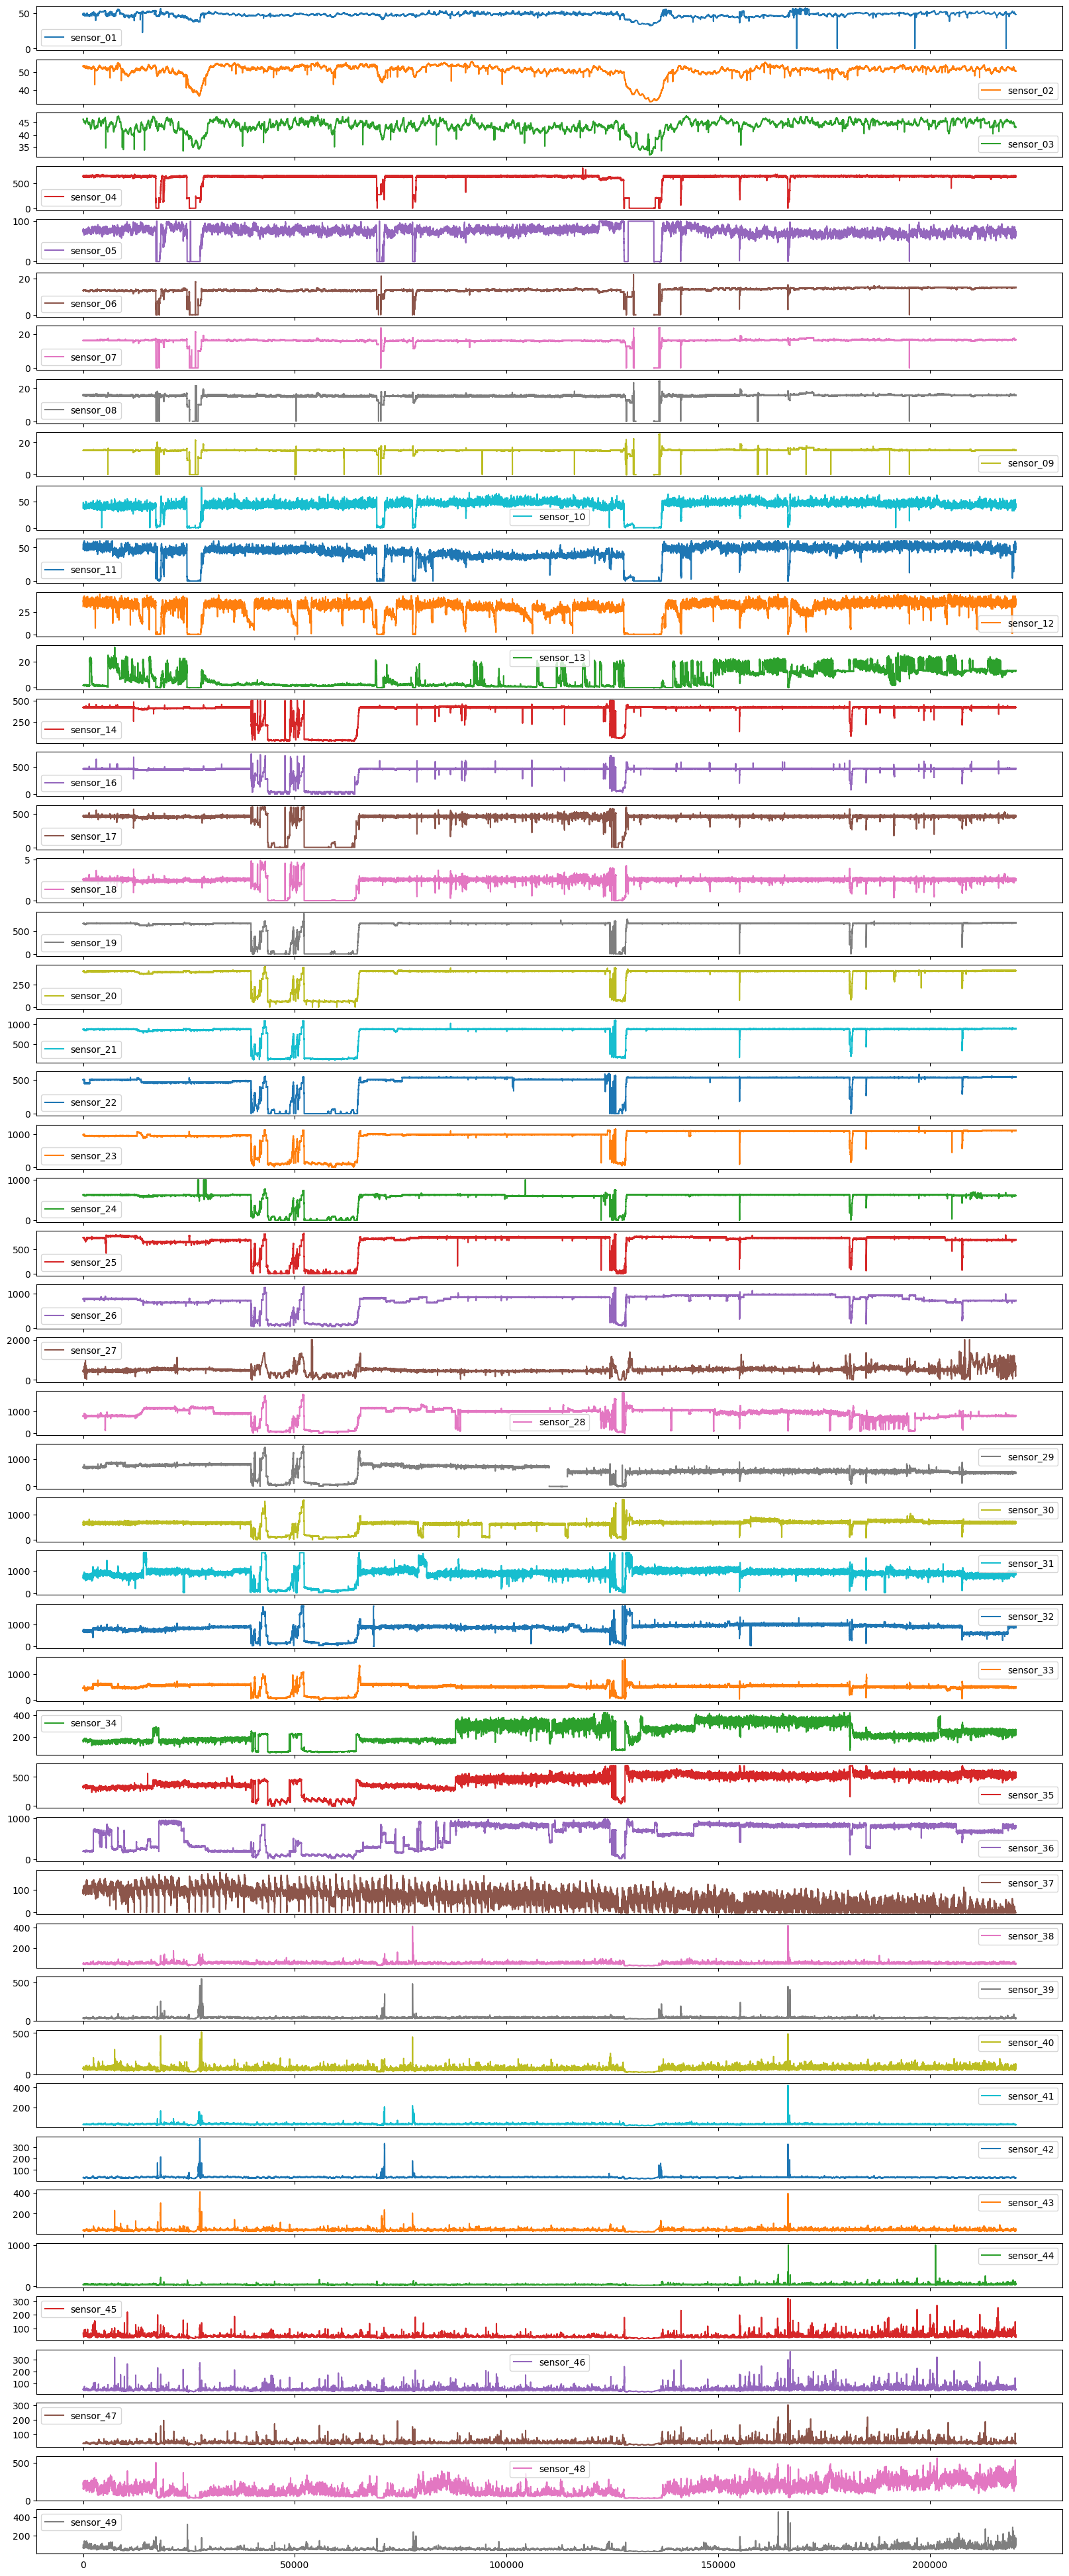

In [70]:
df.plot(subplots =True, sharex = True, figsize = (20,50))

In [71]:
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

Apply a custom scalar absed on machine status to create a column that displays timescale wise when the pump's status is broken, recovering, or normal status

In [72]:
conditions = [(df['machine_status'] == 'NORMAL'), (df['machine_status'] == 'RECOVERING'), (df['machine_status'] == 'BROKEN')]
choices = [1,0.5,0]
df['Operation']  = np.select(condlist=conditions, choicelist=choices)

Plot them again to see the new pattern visualized 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

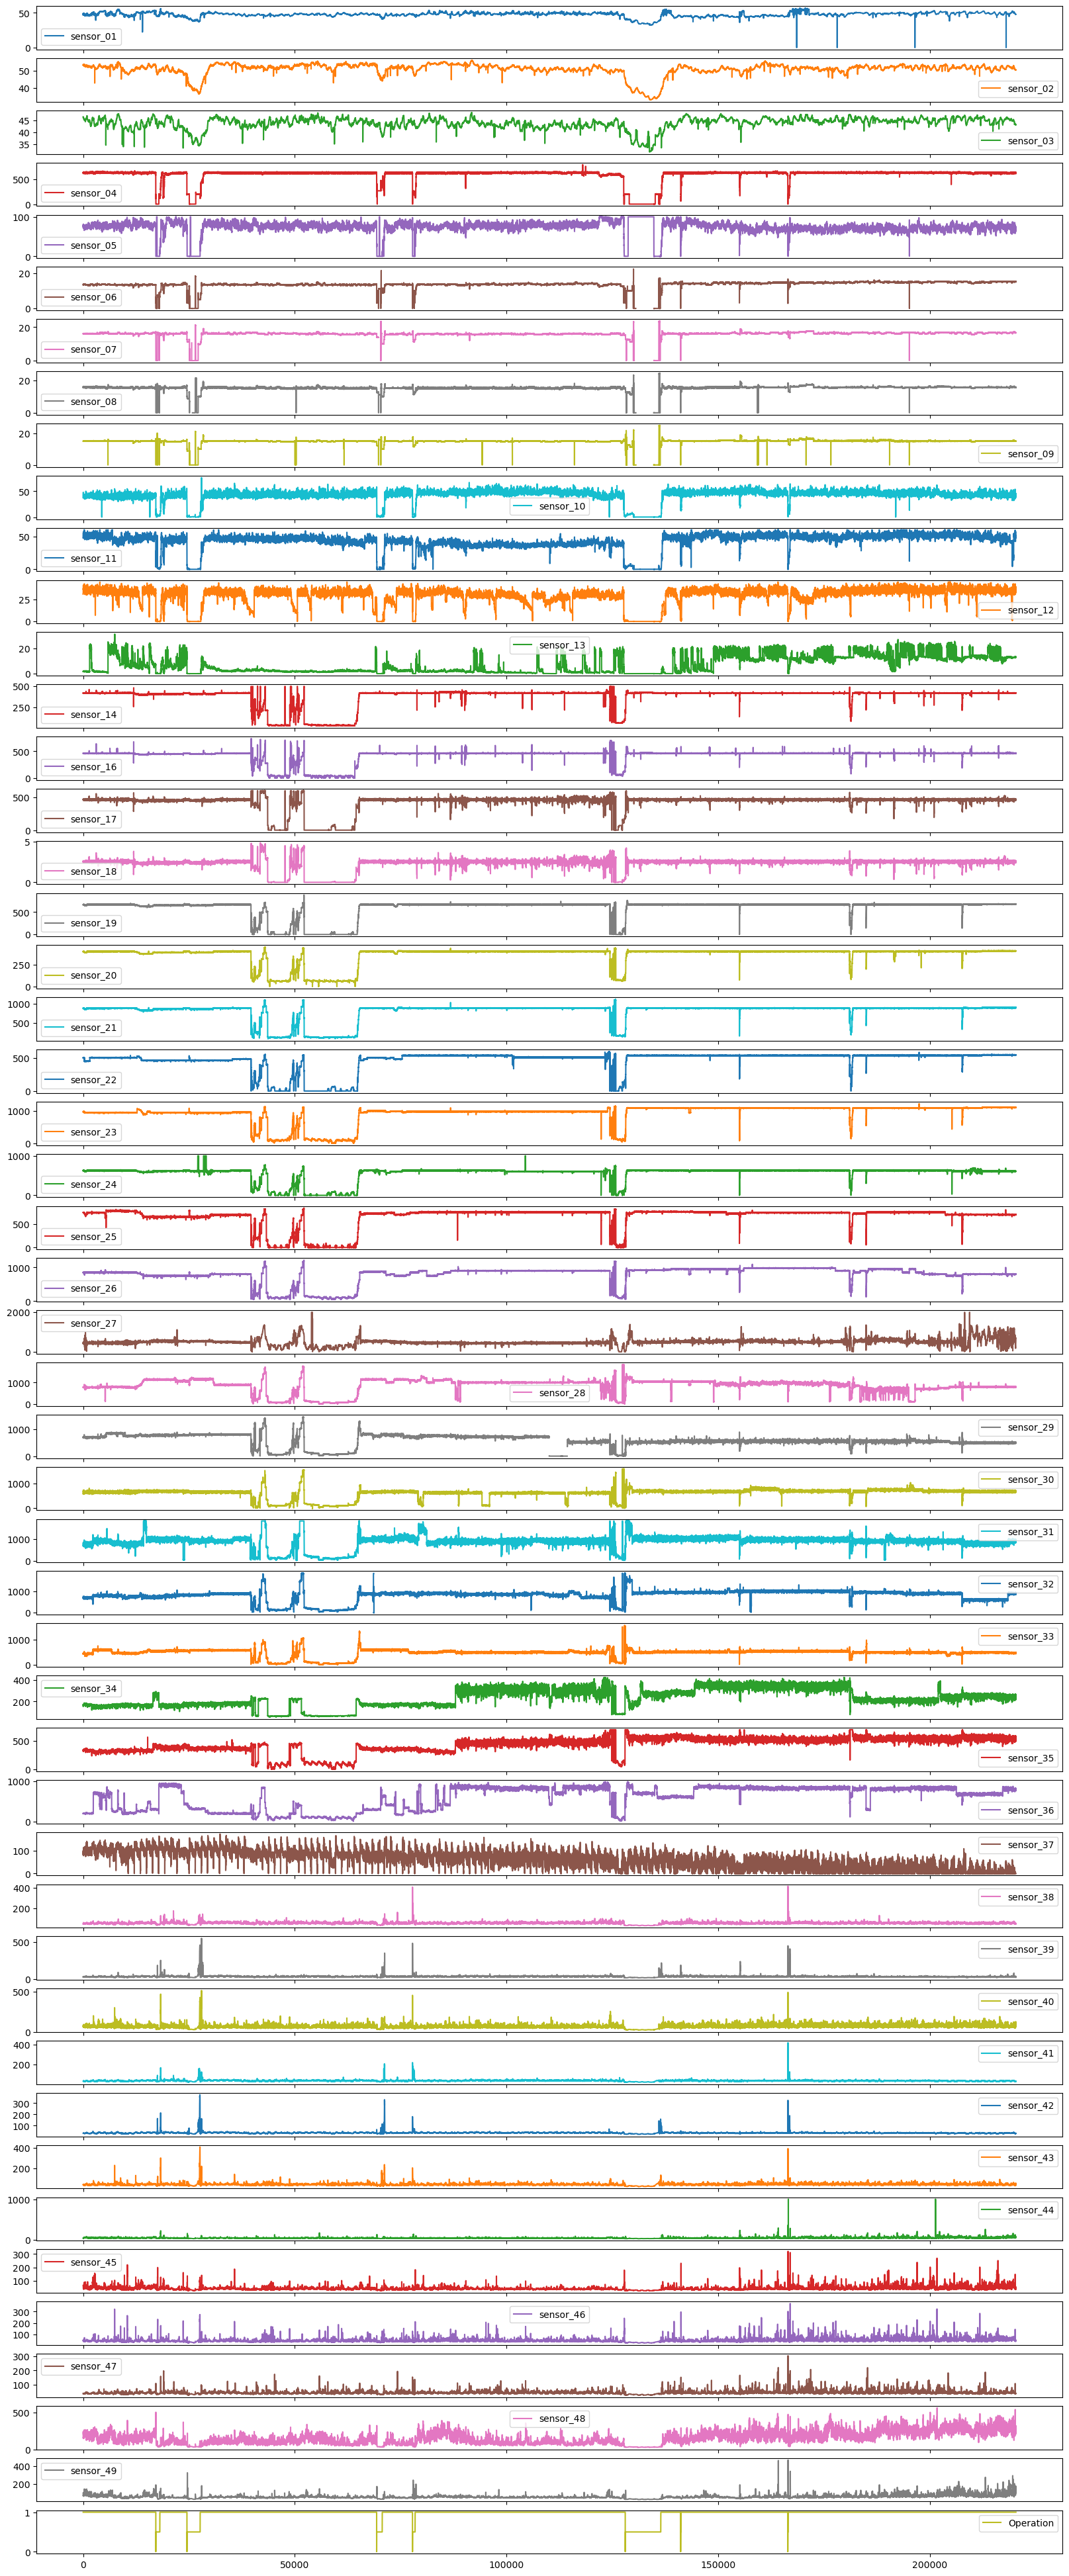

In [73]:
import matplotlib.pyplot as plt
df.plot(subplots =True, sharex = True, figsize = (20,50))

## Create Sub sets based on Columns

In [74]:
df.columns

Index(['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
       'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21',
       'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26',
       'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31',
       'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36',
       'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
       'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46',
       'sensor_47', 'sensor_48', 'sensor_49', 'machine_status', 'Operation'],
      dtype='object')

In [75]:
# Set 0
df0 = pd.DataFrame(df, columns=['Operation','sensor_04','sensor_05','sensor_06','sensor_07','sensor_08','sensor_09'])


In [76]:
# Set 1
df1 = pd.DataFrame(df, columns=['Operation','sensor_01', 'sensor_04', 'sensor_10', 'sensor_14', 'sensor_19', 'sensor_25'])

In [77]:
# Set 2
df2 = pd.DataFrame(df, columns = ['Operation','sensor_02', 'sensor_05', 'sensor_11', 'sensor_16', 'sensor_20', 'sensor_26'])

In [78]:
# Set 3
df3 = pd.DataFrame(df, columns=['Operation', 'sensor_03', 'sensor_06', 'sensor_12', 'sensor_18', 'sensor_21','sensor_27'])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

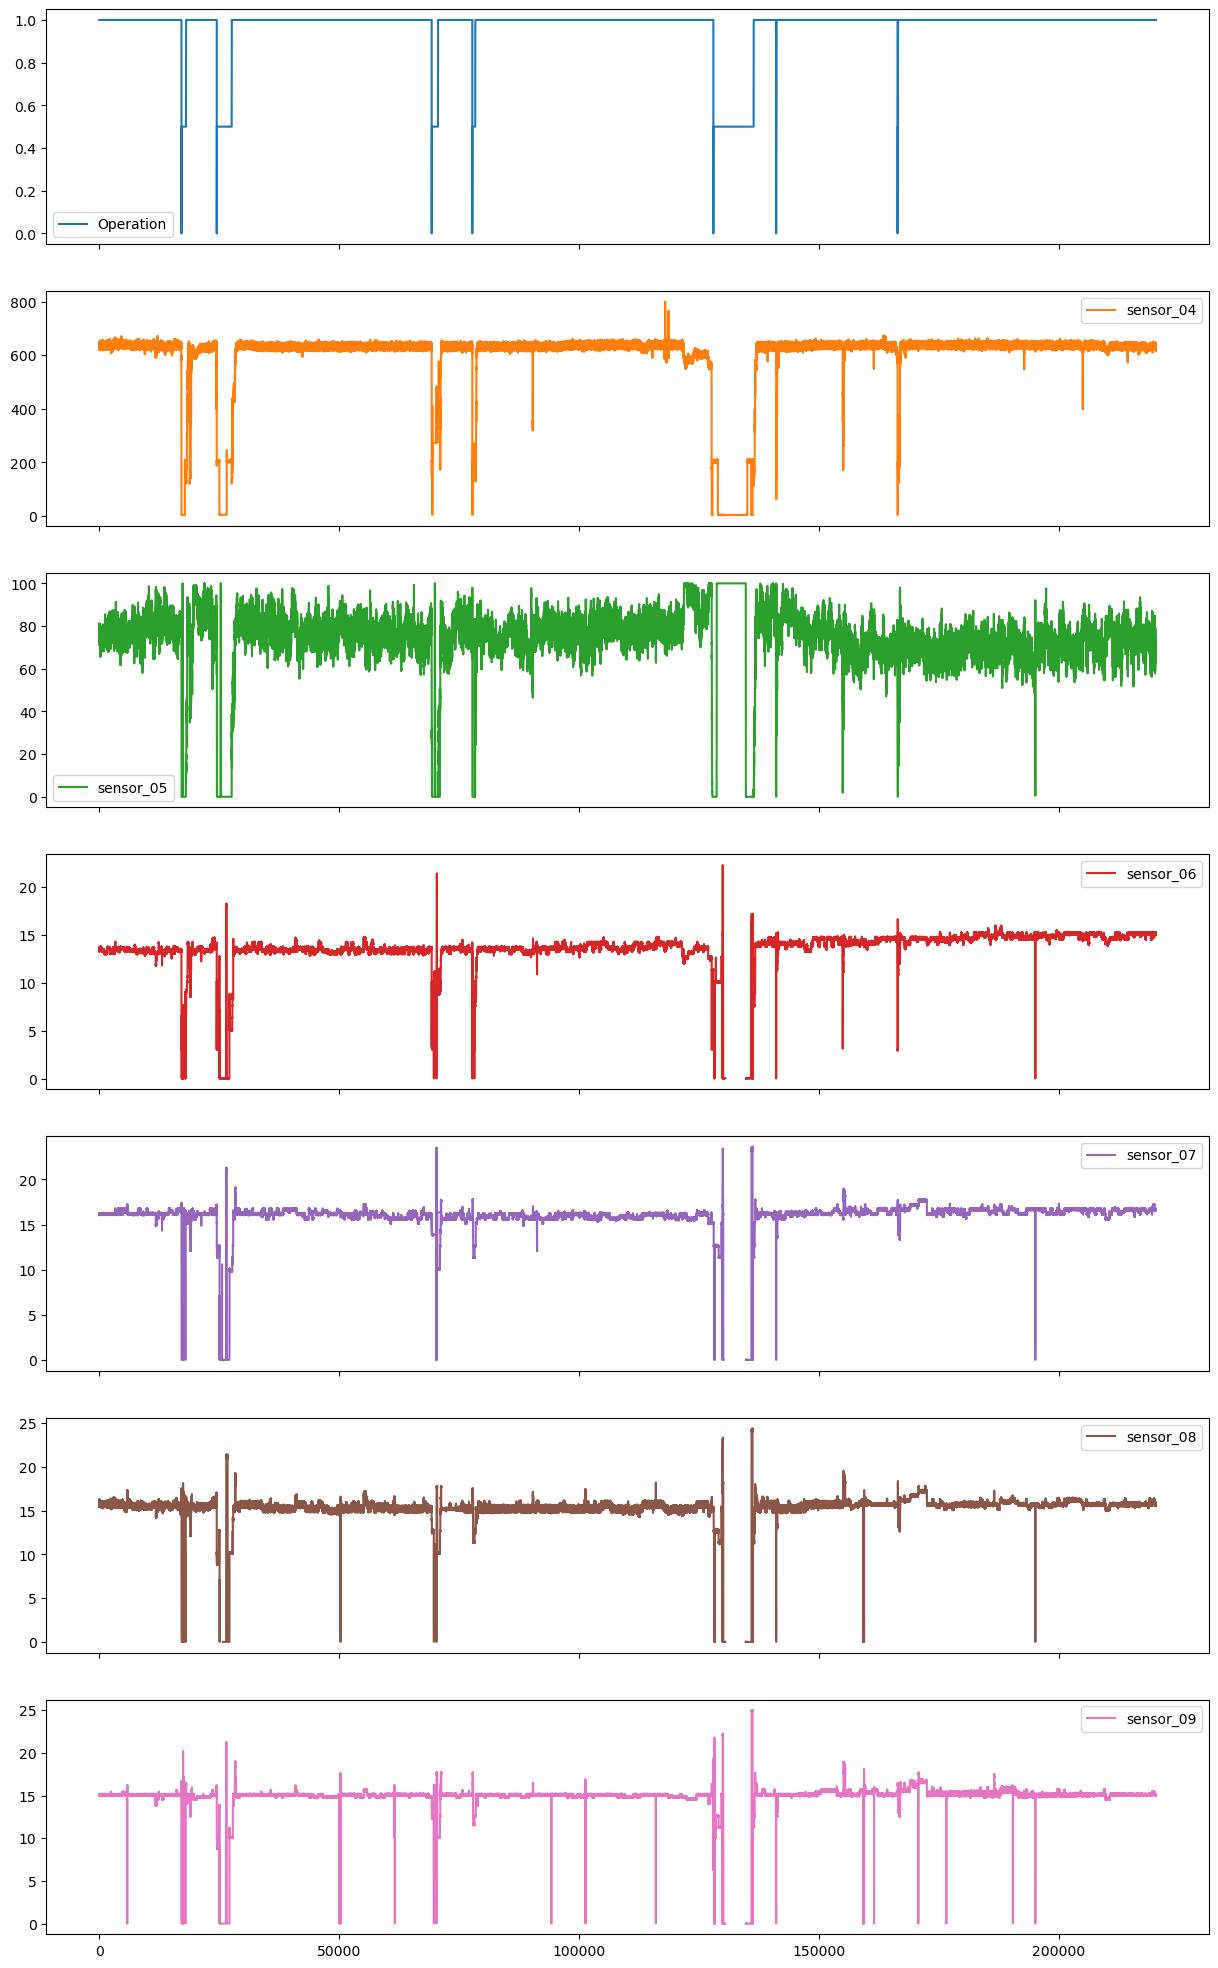

In [79]:
df0.plot(subplots =True, sharex = True, figsize = (15,25))

From this we can see that operation is a key indicator as to when the system has shutdown

Check for outliers via boxplot

<AxesSubplot:xlabel='sensor_07'>

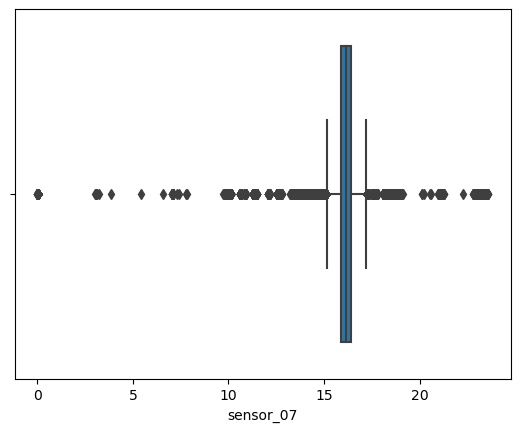

In [28]:
sns.boxplot(x=df['sensor_07'])

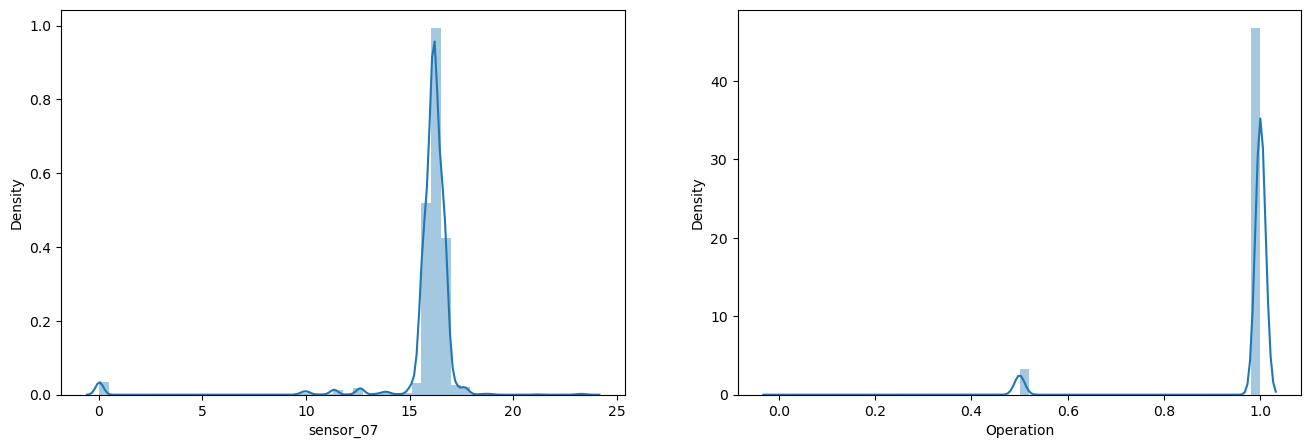

In [30]:
# Create more plots to understand outlier distribution
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['sensor_07'])
plt.subplot(1,2,2)
sns.distplot(df['Operation'])

plt.show()




Find Z-Score to remove outlier

In [28]:
print("Highest allowed",df['Value'].mean() + 3*df['Value'].std())
print("Lowest allowed",df['Value'].mean() - 3*df['Value'].std())

Highest allowed 40.4386589738736
Lowest allowed 7.9690631641091905


In [29]:
# Pre Z-Score corrections
df['Value'].describe()

count    62629.000000
mean        24.203861
std          5.411599
min          6.886155
25%         21.369419
50%         24.550188
75%         27.443794
max        149.601822
Name: Value, dtype: float64

In [30]:



# Set limit bounds
upper_limit = df['Value'].mean() + 3*df['Value'].std()
lower_limit = df['Value'].mean() - 3*df['Value'].std()

# Apply the Z Score
df['Value'] = np.where(
    df['Value']>upper_limit,
    upper_limit,
    np.where(
        df['Value']<lower_limit,
        lower_limit,
        df['Value']
    )
)





In [31]:
df.describe()

,Value,ConvertedTimeStamp
count,62629.000000,62629.000000
mean,24.194034,594.211069
std,5.212866,289.206771
min,7.969063,101.000000
25%,21.369419,414.102000
50%,24.550188,608.144500
75%,27.443794,802.211000
max,40.438659,1231.235500


Replot the graphs

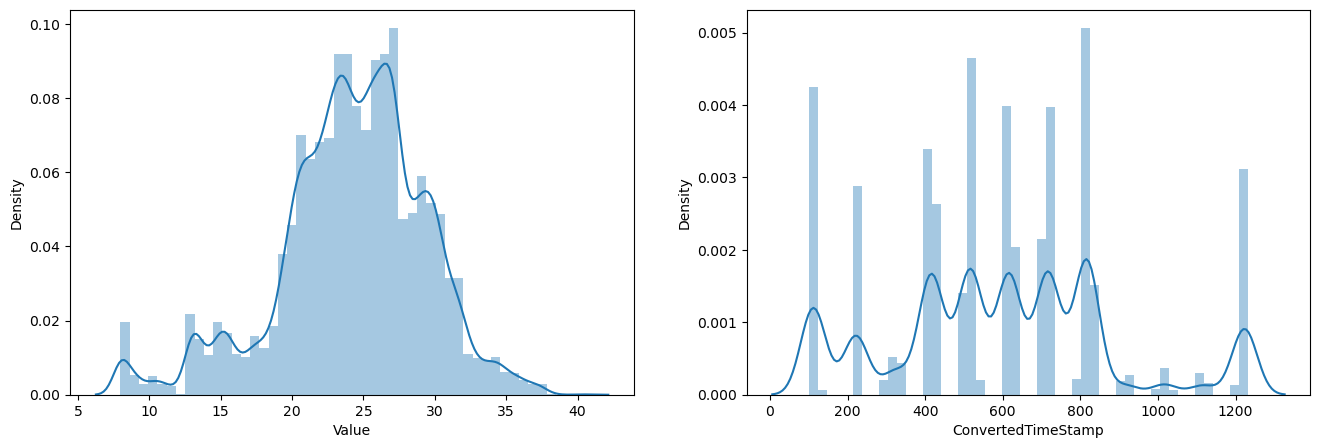

In [32]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['Value'])
plt.subplot(1,2,2)
sns.distplot(df['ConvertedTimeStamp'])
plt.show()


## Begin Understanding some groupings within the data 

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['ConvertedTimeStamp', 'Value' ]])

centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]

## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3],4:cen_x[4]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3],4:cen_y[4]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF','#2FDF20', '#DA95DF']
df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4]})

df.head()

,Timestamp,SensorId,Value,ConvertedTimeStamp,cluster,cen_x,cen_y,c
55042,2017-01-01T00:00:00+03:00,1,13.579168,101.0000,3,155.666688,16.776249,#2FDF20
9439,2017-01-01T00:05:00+03:00,1,13.579168,101.0005,3,155.666688,16.776249,#2FDF20
52357,2017-01-01T00:10:00+03:00,1,13.579168,101.0010,3,155.666688,16.776249,#2FDF20
2838,2017-01-01T00:15:00+03:00,1,13.579168,101.0015,3,155.666688,16.776249,#2FDF20
9126,2017-01-01T00:20:00+03:00,1,13.579168,101.0020,3,155.666688,16.776249,#2FDF20


Plot the clustered data

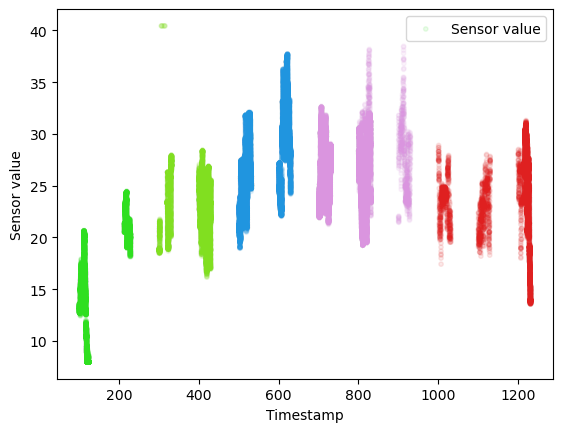

In [34]:
plt.scatter(df.ConvertedTimeStamp, df.Value, c=df.c, alpha = 0.1, s=10 )
plt.legend(['Sensor value'])
plt.xlabel('Timestamp')
plt.ylabel('Sensor value')
plt.show()



In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split



In [36]:
X = df['ConvertedTimeStamp'].values
y = df['Value'].values


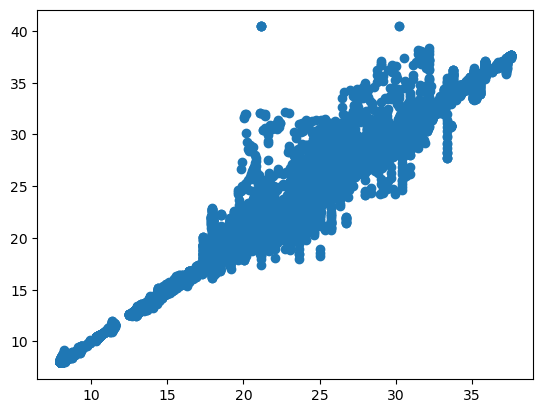

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .9, random_state=0) 

x_train= x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

mod = KNeighborsRegressor().fit(x_train, y_train)




pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsRegressor())
                 ])

pipe.fit(x_train, y_train)

pred = pipe.predict(x_test)

plt.scatter(pred, y_test)



